In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

import matplotlib 
matplotlib.rc('xtick', labelsize=18)
matplotlib.rc('ytick', labelsize=18)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('axes', titlesize=20)
matplotlib.rc('axes', labelsize=20)

%matplotlib inline

In [2]:
df = pd.read_csv('all_weather_data.csv', header=None)
df.columns = ['ZIP', 'station', 'ds', 'metric', 'value']

In [3]:
df.head()

,ZIP,station,ds,metric,value
0,601,GHCND:RQC00660061,2018-01-03T00:00:00,TMAX,82
1,601,GHCND:RQC00660061,2018-01-03T00:00:00,TMIN,53
2,601,GHCND:RQC00660061,2018-01-04T00:00:00,TMAX,81
3,601,GHCND:RQC00660061,2018-01-04T00:00:00,TMIN,59
4,601,GHCND:RQC00660061,2018-01-05T00:00:00,TMAX,82


In [4]:
df2 = df.pivot_table(index=['ZIP', 'ds'], columns='metric', values='value')
df2 = df2.reset_index()
df2.columns.name = None

In [5]:
len(df2['ZIP'].unique())

5579

In [6]:
# Data cleansing:
df3 = df2.copy()

# Drop null
df3 = df3[~df3['TMAX'].isnull()]
df3 = df3[~df3['TMIN'].isnull()]

# Highest recorded temp is 134, anything higher than that is bad data
# Lowest is -80. -99 is used as a null value.
# Biggest swing is 103
df3 = df3[df3['TMAX'] < 134]
df3 = df3[df3['TMIN'] > -80]
df3 = df3[df3['TMAX'] - df3['TMIN'] < 103]

# TMAX should be >= TMIN
df3 = df3[df3['TMAX'] >= df3['TMIN']]

# Drop territories (PR, etc.)
df3 = df3[(df3['ZIP'] > 1000)]
df3 = df3[(df3['ZIP'] < 96200) | (df3['ZIP'] >= 96700)]

In [7]:
# Limit to stations with at most 1 week of missing data
z = df3.groupby('ZIP').aggregate('count').reset_index()
z = z[(z['TMAX'] >= 358) & (z['TMIN'] >= 358)]

In [8]:
zip_use = set(list(z['ZIP'].values))

In [9]:
len(zip_use)

3944

In [10]:
stations = pd.read_csv('stations.csv', header=None)
stations.columns = ['ZIP', 'station', 'lat', 'long', 'null']
stations = stations[['ZIP', 'station', 'lat', 'long']]
stations.head()

,ZIP,station,lat,long
0,601,GHCND:RQC00660061,18.1747,-66.7977
1,602,GHCND:RQC00662801,18.3808,-67.1569
2,603,NaN,NaN,NaN
3,606,GHCND:RQC00665908,18.1511,-66.9888
4,610,NaN,NaN,NaN


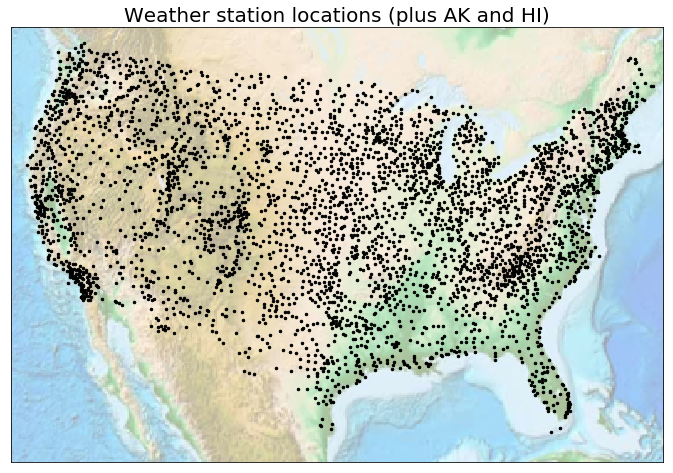

In [11]:
# Plot locations of the weather stations

fig = plt.figure(figsize=(12, 8))
m = Basemap(projection='lcc', resolution=None,
            width=4.8E6, height=3.2E6, 
            lat_0=38, lon_0=-97,)
m.etopo(scale=0.6, alpha=0.4)

for _, row in stations.iterrows():
    if row['ZIP'] in zip_use:
        x, y = m(row['long'], row['lat'])
        plt.plot(x, y, '.', markersize=5, c='k')

ax = fig.gca()
ax.set_title('Weather station locations (plus AK and HI)');

plt.savefig('station_map.png', pad_inches=0, bbox_inches = 'tight')

In [12]:
df4 = df3[df3['ZIP'].isin(zip_use)].copy()

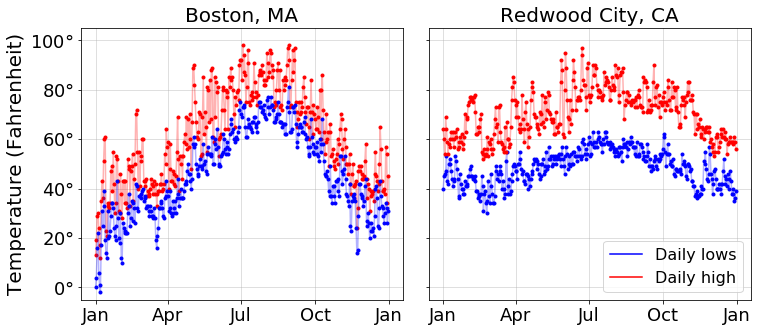

In [13]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121)

df_bos = df4[df4['ZIP'] == 2128].copy()
df_bos['ds'] = pd.to_datetime(df_bos['ds'])

ax.plot(df_bos['ds'], df_bos['TMAX'], 'r.')
ax.plot(df_bos['ds'], df_bos['TMAX'], 'r-', alpha=0.3)
ax.plot(df_bos['ds'], df_bos['TMIN'], 'b.')
ax.plot(df_bos['ds'], df_bos['TMIN'], 'b-', alpha=0.3)

ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels([r'$0\degree$', r'$20\degree$', r'$40\degree$', r'$60\degree$', r'$80\degree$', r'$100\degree$'])
ax.set_ylabel('Temperature (Fahrenheit)')
ax.set_ylim([-5, 105])
ax.set_xticks(pd.to_datetime([
    '2018-01-01', '2018-04-01', '2018-07-01', '2018-10-01', '2019-01-01'
]))
ax.set_xticklabels(['Jan', 'Apr', 'Jul', 'Oct', 'Jan'])
ax.grid(True, alpha=0.5)
ax.set_title('Boston, MA')

ax = fig.add_subplot(122)
df_phx = df4[df4['ZIP'] == 94062].copy()
df_phx['ds'] = pd.to_datetime(df_phx['ds'])

ax.plot(df_phx['ds'], df_phx['TMIN'], 'b-', alpha=0.3)
ax.plot(df_phx['ds'], df_phx['TMAX'], 'r-', alpha=0.3)
ax.plot(df_phx['ds'], df_phx['TMIN'], 'b.')
ax.plot(df_phx['ds'], df_phx['TMAX'], 'r.')

ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_ylim([-5, 105])
ax.set_xticks(pd.to_datetime([
    '2018-01-01', '2018-04-01', '2018-07-01', '2018-10-01', '2019-01-01'
]))
ax.set_xticklabels(['Jan', 'Apr', 'Jul', 'Oct', 'Jan'])
ax.set_yticklabels([])
ax.grid(True, alpha=0.5)
ax.set_title('Redwood City, CA')
legend = ax.legend(['Daily lows', 'Daily high'], loc='lower right')
for lh in legend.legendHandles: 
    lh.set_alpha(1)

fig.subplots_adjust(wspace=0.08)

plt.savefig('temp_data.png', pad_inches=0, bbox_inches = 'tight')

In [14]:
df4.head()

,ZIP,ds,TMAX,TMIN
5680,1003,2018-01-01T00:00:00,12.0,-9.0
5681,1003,2018-01-02T00:00:00,11.0,-14.0
5682,1003,2018-01-03T00:00:00,21.0,-14.0
5683,1003,2018-01-04T00:00:00,23.0,-1.0
5684,1003,2018-01-05T00:00:00,24.0,8.0


In [15]:
# Join with population
df_pop = pd.read_csv('Gaz_zcta_national.txt', delimiter='\t')

# Drop territories (PR, etc.)
df_pop = df_pop[(df_pop['GEOID'] > 1000)]
df_pop = df_pop[(df_pop['GEOID'] < 96200) | (df_pop['GEOID'] >= 96700)]

In [16]:
df_pop.head()

,GEOID,POP10,HU10,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
131,1001,16769,7557,29635470,2229770,11.442,0.861,42.062332,-72.628274
132,1002,29049,10388,142556362,4280260,55.041,1.653,42.363977,-72.458507
133,1003,10372,5,1842384,12788,0.711,0.005,42.389941,-72.524108
134,1005,5079,2044,114586903,667042,44.242,0.258,42.418848,-72.106598
135,1007,14649,5839,136345999,6943853,52.643,2.681,42.279010,-72.400468


In [17]:
# Map every zip to the closest one (in zip space) with weather data to compute total population
zip_use_list = list(sorted(zip_use))
i = 0
pops = {zipc: 0 for zipc in zip_use_list}
for _, row in df_pop.iterrows():
    # Check if we should increment current weather zip.
    while (
        (i < len(zip_use_list) - 1) and
        (abs(row['GEOID'] - zip_use_list[i + 1]) < abs(row['GEOID'] - zip_use_list[i]))
    ):
        i += 1
    pops[zip_use_list[i]] += row['POP10']

In [18]:
df_zip_pops = pd.DataFrame({'ZIP': list(pops.keys()), 'POP': list(pops.values())})

In [19]:
df_zip_pops.head()

,ZIP,POP
0,1003,61269.0
1,1007,189468.0
2,1077,114569.0
3,1085,84251.0
4,1098,179955.0


In [20]:
df5 = pd.merge(df4, df_zip_pops, on='ZIP', how='left')

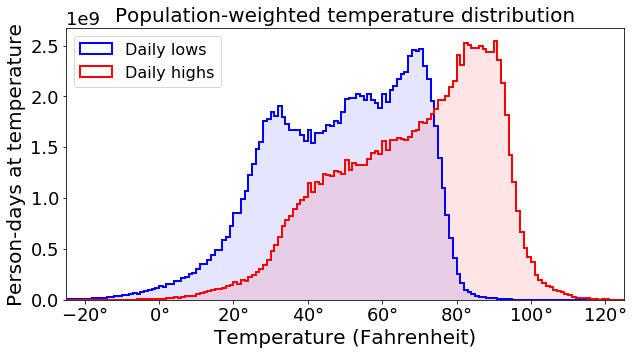

In [21]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)


n_min, bins_min, _ = ax.hist(
    df5['TMIN'].values,
    bins=np.arange(-25, 126, 1),
    weights=df5['POP'],
    color='b',
    histtype='step',
    lw=2,
    zorder=5,
);
n_max, bins_max, _ = ax.hist(
    df5['TMAX'].values,
    bins=np.arange(-25, 126, 1),
    weights=df5['POP'],
    color='r',
    histtype='step',
    lw=2,
    zorder=5,
);

ax.hist(
    df5['TMIN'].values,
    bins=np.arange(-25, 126, 1),
    weights=df5['POP'],
    color='b',
    histtype='bar',
    edgecolor='None',
    alpha=0.1
);
ax.hist(
    df5['TMAX'].values,
    bins=np.arange(-25, 126, 1),
    weights=df5['POP'],
    color='r',
    histtype='bar',
    edgecolor='None',
    alpha=0.1
);
ax.set_xlim([-25, 125]);
ax.set_xticks([-20, 0, 20, 40, 60, 80, 100, 120])
ax.set_xticklabels([
    r'$-20\degree$', r'$0\degree$', r'$20\degree$', r'$40\degree$',
    r'$60\degree$', r'$80\degree$', r'$100\degree$', r'$120\degree$'
]);
ax.set_xlabel('Temperature (Fahrenheit)')
ax.set_ylabel('Person-days at temperature')
ax.set_title('Population-weighted temperature distribution')
ax.legend(['Daily lows', 'Daily highs']);

plt.savefig('temp_distr.png', pad_inches=0, bbox_inches = 'tight')

In [22]:
# Compute CDF
z = np.cumsum(n_min)
cdf_min = z/z[-1]

z = np.cumsum(n_max)
cdf_max = z/z[-1]

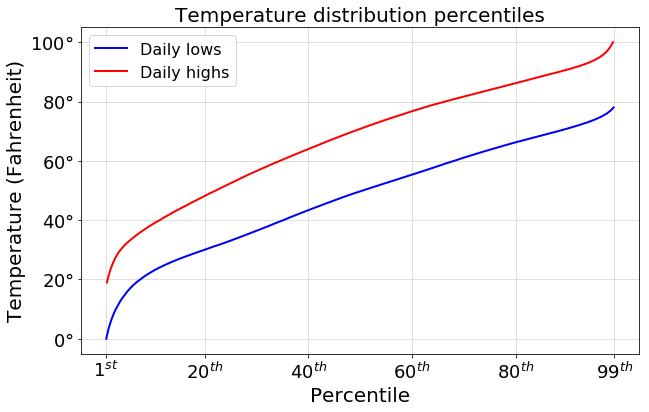

In [23]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
i_plt_min = (cdf_min >= 0.01) & (cdf_min <= 0.99)
i_plt_max = (cdf_max >= 0.01) & (cdf_max <= 0.99)
ax.plot(cdf_min[i_plt_min], bins_min[:-1][i_plt_min], 'b-', lw=2)
ax.plot(cdf_max[i_plt_max], bins_max[:-1][i_plt_max], 'r-', lw=2)
#ax.axhline(y=100, c='gray', ls='--')
#ax.axhline(y=0, c='gray', ls='--')
ax.set_xticks([0.01, 0.20, 0.40, 0.60, 0.80, 0.99])
ax.set_xticklabels([r'$1^{st}$', r'$20^{th}$', r'$40^{th}$', r'$60^{th}$', r'$80^{th}$', r'$99^{th}$', ])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels([r'$0\degree$', r'$20\degree$', r'$40\degree$', r'$60\degree$', r'$80\degree$', r'$100\degree$'])
ax.set_ylabel('Temperature (Fahrenheit)')
ax.set_xlabel('Percentile')
ax.legend(['Daily lows', 'Daily highs'])
ax.grid(True, alpha=0.5)
ax.set_title('Temperature distribution percentiles');
plt.savefig('temp_percentiles.png', pad_inches=0, bbox_inches = 'tight')